In [2]:
pip install opencv_python

You should consider upgrading via the 'c:\Users\sagar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
from glob import glob
import os

In [3]:
dataset_path = r'C:\Users\sagar\Desktop\plastic_classification\dataset\Dataset'

In [4]:
train_path = dataset_path
test_path = dataset_path

In [5]:
x_data, y_data = [], []
for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        if img_array is not None:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            x_data.append(img_array)
            y_data.append(category.split(os.sep)[-1])  # Folder name as label


100%|██████████| 130/130 [00:01<00:00, 65.17it/s]


In [6]:
data = pd.DataFrame({'image': x_data, 'label': y_data})


In [7]:
print(data['label'].value_counts())

label
Biodegradable Images    130
Trash Images            130
Recyclable Images       129
Name: count, dtype: int64


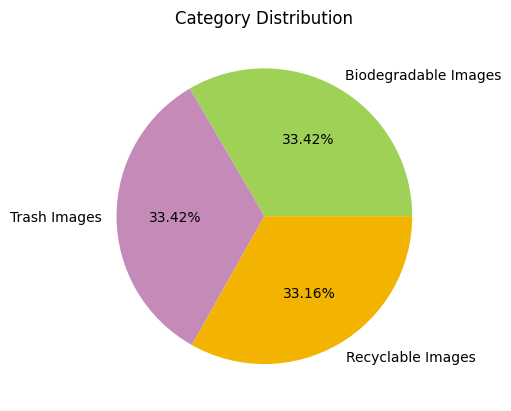

In [9]:
data_counts = data['label'].value_counts()
colors = ['#a0d157', '#c48bb8', '#f2b400']
plt.pie(data_counts.values, labels=data_counts.index, colors=colors, autopct='%0.2f%%')
plt.title("Category Distribution")
plt.show()


In [10]:
# Model definition
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\sagar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Model summary
model.summary()

Found 389 images belonging to 3 classes.
Found 389 images belonging to 3 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,261,315 (84.92 MB)

 Trainable params: 22,261,315 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Set the number of epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

c:\Users\sagar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3508 - loss: 1.4374 - val_accuracy: 0.5833 - val_loss: 0.9212
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2500 - loss: 1.0996

c:\Users\sagar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2500 - loss: 1.0996 - val_accuracy: 0.5911 - val_loss: 0.9119
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5749 - loss: 0.9262 - val_accuracy: 0.6849 - val_loss: 0.7641
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.7500 - loss: 0.8027 - val_accuracy: 0.6693 - val_loss: 0.7704
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6152 - loss: 0.8006 - val_accuracy: 0.6432 - val_loss: 0.6404
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.7500 - loss: 0.5398 - val_accuracy: 0.6172 - val_loss: 0.6826
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6524 - loss: 0.7857 - val_accuracy: 0.7109 - val_loss: 0.5461
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.6875 - loss: 0.5472 - val_accuracy: 0.7370 - val_loss: 0.5336
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6782 - loss: 0.6766 - val_accuracy: 0.7422 - val_loss: 0.

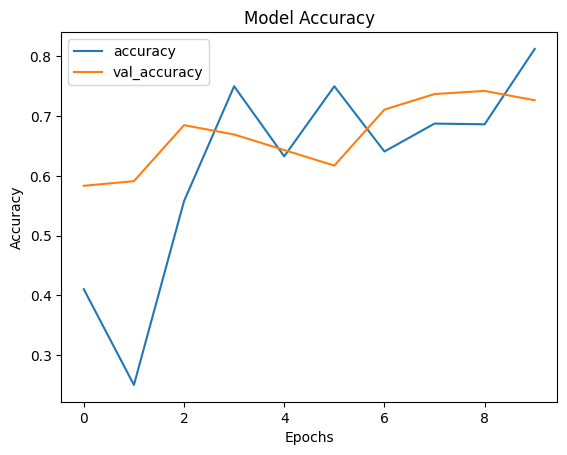

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

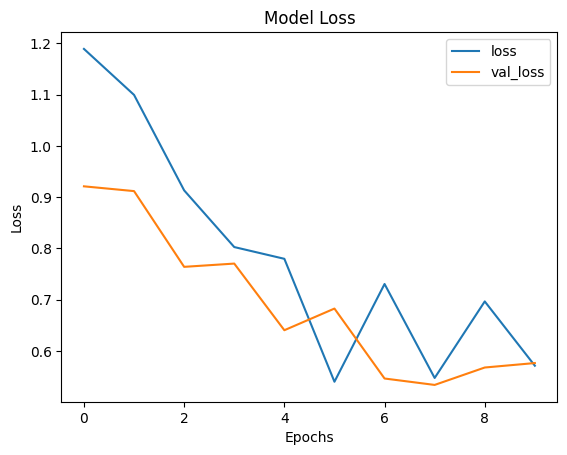

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [15]:
def test_sample_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    class_names = train_generator.class_indices
    predicted_class = list(class_names.keys())[np.argmax(prediction)]
    print(f"Predicted Class: {predicted_class}")


In [16]:
test_sample_image(r'C:\Users\sagar\Desktop\plastic_classification\dataset\Dataset\Recyclable Images\cardboard11.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Recyclable Images


In [17]:
test_sample_image(r'C:\Users\sagar\Desktop\plastic_classification\dataset\Dataset\Biodegradable Images\TRAIN.2_BIODEG_ORI_11315.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Biodegradable Images
